# Protein Folding Principles Dataset

In [1]:
import matplotlib.pyplot as plt

In [2]:
#Change root directory to the project root
#This is necessary to import modules from the project
#without having to install them

import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [3]:
## Interactive reloading
#This is useful for Jupyter notebooks to automatically reload modules

%load_ext autoreload
%autoreload 2

## Get PDB codes for high quality structures using PISCES

In [9]:
from dataset.pisces import fetch_pisces_table, get_filtered_pdb_codes

# Fetch and filter
pisces_df = fetch_pisces_table()
pdb_ids = get_filtered_pdb_codes(pisces_df)

# Preview results
print(f"Found {len(pdb_ids)} high-quality structures with pdb codes.")
print(pdb_ids[:10])


Detected PISCES columns: ['PDBchain', 'len', 'method', 'resol', 'rfac', 'freerfac']
Found 11116 high-quality structures with pdb codes.
['5D8V', '5NW3', '1UCS', '3X2M', '2VB1', '1US0', '6E6O', '6S2M', '1R6J', '4REK']


## Find beta-beta patterns and their chirality in PDB entries

In [ ]:
from dataset.io_utils import fetch_mmcif_file, run_dssp_on_mmcif
from dataset.motif_logic import detect_hairpins, identify_strands, assign_beta_chirality_strand_axis, assign_beta_chirality_local
import pandas as pd
import os

#pdb_ids = ["8GBS", "7R1C"]  # or a longer list
results_strandaxis = []
results_local = []

for pdb_id in pdb_ids[0:150]:
    pdb_path = fetch_mmcif_file(pdb_id, outdir="./pdb_files")
    try:
        model, dssp_df = run_dssp_on_mmcif(pdb_path, dssp_exe="/opt/anaconda3/envs/folding-dssp/bin/mkdssp")
        if dssp_df is None:
            print(f"DSSP failed for {pdb_id}. Skipping.")
            continue

        hairpin_annotations = detect_hairpins(dssp_df)

        # Chirality by strand axis + midpoint vector + CB
        df_strandaxis = assign_beta_chirality_strand_axis(model, dssp_df, hairpin_annotations)
        results_strandaxis.append(df_strandaxis)

        # Chirality by backbone geometry (N→C, CA→CA, CA→CB)
        df_local = assign_beta_chirality_local(model, dssp_df, hairpin_annotations)
        results_local.append(df_local)
    except Exception as e:
        print(f"Error processing {pdb_id}: {e}")
        continue
    finally:
        pass
        # Optional: clean up
        # if os.path.exists(pdb_path):
        #     os.remove(pdb_path)

all_hairpins_strandaxis = pd.concat(results_strandaxis, ignore_index=True)
all_hairpins_local = pd.concat(results_local, ignore_index=True)

#print(all_hairpins_backbone.head(10))
all_hairpins_local


<Axes: xlabel='Loop length', ylabel='Frequency'>

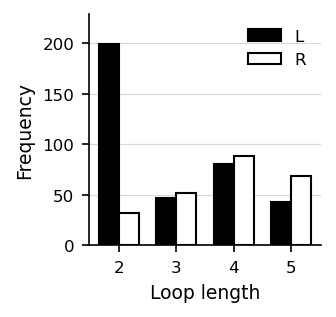

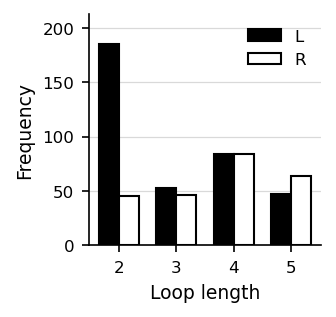

In [ ]:
from dataset.plots import plot_loop_length_chirality

plot_loop_length_chirality(all_hairpins_strandaxis)   
plot_loop_length_chirality(all_hairpins_local) 

### What are those R hairpins with length 2?

None of these were observed in the paper. Maybe many of those are quite weak magnitude?

In [ ]:
all_hairpins_local[(all_hairpins_local["loop_len"] == 2) & (all_hairpins_local["handedness"] == "R")].head(10)


,Chain,strand1_start_idx,strand1_end_idx,strand2_start_idx,strand2_end_idx,strand1_start_res,strand1_end_res,strand2_start_res,strand2_end_res,loop_len,HairpinSequence,LoopSequence,FullChainSequence,PDB,handedness,handedness_magnitude
34,A,179,182,185,192,198,201,204,215,2,PVVCSGKLQGIVSW,SG,IVGGYTCGANTVPYQVSLNSGYHFCGGSLINSQWVVSAAHCYKSGI...,4i8h,R,0.011036
36,A,3,10,13,22,9,16,19,28,2,RCFFDIAINNQPAGRVVFEL,NN,QRPRCFFDIAINNQPAGRVVFELFSDVCPKTCENFRCLCTGEKGTG...,2wfi,R,0.720827
74,A,13,24,27,33,1014,1025,1028,1034,2,YPLRLIDKEVVNHDTRRFRFA,HD,STPAITLENPDIKYPLRLIDKEVVNHDTRRFRFALPSPEHILGLPV...,5gv8,R,0.724589
80,A,138,141,144,150,1139,1142,1145,1151,2,VIKTVKSVGMIAG,VK,STPAITLENPDIKYPLRLIDKEVVNHDTRRFRFALPSPEHILGLPV...,5gv8,R,0.201661
100,AAA,90,101,104,114,97,108,111,121,2,RVMDPTCIVANIQGRETILVMVGKW,QG,VVFKAEGEHFTDQKGNTIVGSGSGGTTKYFRIPAMCTTSKGTIVVF...,7af2,R,0.015462
117,A,85,87,90,99,116,118,121,130,2,VKTKFGYHIIMVEGR,KF,GPMGSNAVKVRHILCEKHGKIMEAMEKLKSGMRFNEVAAQYSEDKA...,3ui4,R,0.103790
130,A,20,24,27,32,45,48,49,54,2,FSVTRGATKGFVT,GA,ANIVGGIEYSINNASLCSVGFSVTRGATKGFVTAGHCGTVNATARI...,2h5c,R,0.321991
131,A,42,45,48,57,62,66,82,91,2,TARIGGAVVGTFAARV,GG,ANIVGGIEYSINNASLCSVGFSVTRGATKGFVTAGHCGTVNATARI...,2h5c,R,0.554396
143,A,113,125,128,139,113,125,128,139,2,PQLRISWIRSKSLDGVAYEDFIMSTVR,DG,FLTAVSSIDTFLPVLNEAKLQWPTSALAASSEELLGGYVGSQFYLQ...,8c3x,R,0.316167
174,A,187,195,198,208,189,197,200,210,2,AVNLKSLNYNGDNSNAGFGVVV,NG,SPSSPLYFEGPSYGIRVSVGSNKQEQQVVLDTGSSDFWVVDSSASC...,4y9w,R,0.093399


### Plot only strng magnitude ones

<Axes: xlabel='Loop length', ylabel='Frequency'>

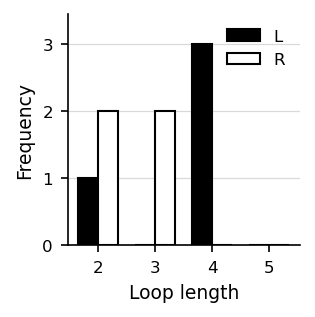

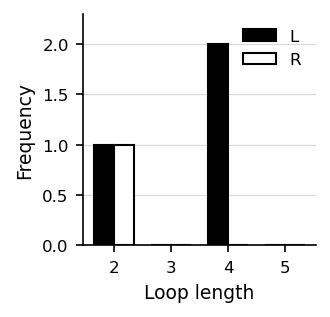

In [21]:
plot_loop_length_chirality(all_hairpins_backbone[all_hairpins_backbone["handedness_magnitude"].abs() > 0.75])
plot_loop_length_chirality(all_hairpins_exact[all_hairpins_exact["handedness_magnitude"].abs() > 0.75])

# Writeout all hairpins in a single pdb file

In [16]:
"""
Write an mmCIF with the first 20 β-hairpins that satisfy

    • loop_len ≤ 5
    • handedness == "L"
    • |handedness_magnitude| > 0.8
    • each flanking β-strand ≥ 5 residues

**Alignment frame (backbone method)**  
    origin      = CA of residue *before* the loop (res_pre = strand1_end)  
    +x (u-axis) = N→C vector of res_pre                              (backbone)  
    +y (v-axis) = CA_pre → CA_post, projected ⟂ u                    (across loop)  
    +z (w-axis) = u × v                                              (right-handed)

Each hairpin is copied into this frame (so all overlay) and stored in its own
chain HP_0001 … HP_0020 in **hairpins_backbone_aligned.cif**.
"""

from copy import deepcopy
import numpy as np
from Bio.PDB import MMCIFParser, MMCIFIO, Structure, Model, Chain, Vector

from dataset.io_utils  import fetch_mmcif_file
from dataset.geometry  import get_ca_from_residue, get_cb_from_residue
from dataset.motif_logic import compute_handedness_from_backbone_geometry   # already imported earlier

# ───────────────────────────── 1 · filter DataFrame
HP_DF = (
    all_hairpins_backbone
      .query(
          "loop_len == 2 and handedness == 'L' "
          "and abs(handedness_magnitude) > 0.8 "
          "and (strand1_end - strand1_start + 1) >= 5 "
          "and (strand2_end - strand2_start + 1) >= 5"
      )
      #.head(20)        # keep first 20
      .reset_index(drop=True)
)
print(f"{len(HP_DF)} hairpins selected")

# ───────────────────────────── 2 · Bio.PDB setup
parser    = MMCIFParser(QUIET=True)
structure = Structure.Structure("BACKBONE_ALIGNED")
model0    = Model.Model(0)
structure.add(model0)

def np_vec(v: Vector):
    """Return numpy array from Bio.PDB.Vector"""
    return v.get_array()

# ───────────────────────────── 3 · iterate hairpins
for i, row in HP_DF.iterrows():
    pdb_id, cid = row["PDB"].lower(), row["Chain"]
    s1_start, s1_end = int(row["strand1_start"]), int(row["strand1_end"])
    s2_start, s2_end = int(row["strand2_start"]), int(row["strand2_end"])

    # source structure
    model_src = parser.get_structure(pdb_id, fetch_mmcif_file(pdb_id))[0]
    if cid not in model_src:
        continue
    chain_src = model_src[cid]

    try:
        res_pre  = chain_src[(" ", s1_end,   " ")]  # before loop
        res_post = chain_src[(" ", s2_start, " ")]  # after  loop
    except KeyError:
        continue

    # backbone frame
    ca_pre = np_vec(get_ca_from_residue(res_pre))
    ca_post= np_vec(get_ca_from_residue(res_post))
    if ca_pre is None or ca_post is None:
        continue

    u = np_vec(Vector(res_pre["C"].get_coord()) - Vector(res_pre["N"].get_coord()))
    u /= np.linalg.norm(u)

    v_raw = ca_post - ca_pre
    v_raw -= np.dot(v_raw, u) * u
    v = v_raw / np.linalg.norm(v_raw)

    w = np.cross(u, v)
    R = np.vstack((u, v, w)).T            # local→global; use R.T to rotate coords into frame

    # copy residues, transform
    new_chain = Chain.Chain(f"HP_{i+1:04d}")
    for resseq in range(s1_start, s2_end + 1):
        key = (" ", resseq, " ")
        if key not in chain_src:
            continue
        res = deepcopy(chain_src[key])
        for atom in res.get_atoms():
            xyz = atom.get_vector().get_array() - ca_pre   # translate to origin
            atom.set_coord(R.T @ xyz)                      # rotate into frame
        new_chain.add(res)

    model0.add(new_chain)

# ───────────────────────────── 4 · write mmCIF
out_cif = "hairpins_backbone_aligned.cif"
writer  = MMCIFIO()
writer.set_structure(structure)
writer.save(out_cif)

print(f"✓ saved {len(model0.child_list)} aligned hairpins → {out_cif}")


0 hairpins selected
✓ saved 0 aligned hairpins → hairpins_backbone_aligned.cif


# Other sanity checks

### Check C-b generation function

In [17]:
"""
Generate a minimal Ala residue, compute its Cβ with the library function
`get_cb_from_residue`, and write the four atoms to *test_ala_cb.pdb*.

Run this after you have installed the project (so that
`dataset.geometry.get_cb_from_residue` is importable).
"""

import math
import numpy as np
from pathlib import Path
from Bio.PDB import Atom, Residue, Vector
from dataset.geometry import get_cb_from_residue, CA_CB_BOND

# ───────────────────────────────────────────────────────────────── backbone coords
# realistic peptide geometry (Engh & Huber)
CA = np.array([0.000, 0.000, 0.000])
N  = np.array([1.458, 0.000, 0.000])                      # CA–N  1.458 Å
C  = np.array([
    1.525 * math.cos(math.radians(110.0)),                # CA–C  1.525 Å
    1.525 * math.sin(math.radians(110.0)),
    0.000
])

# ───────────────────────────────────────────────────────────────── build residue
res = Residue.Residue((" ", 1, " "), "ALA", "")
res.add(Atom.Atom("N",  N,  0.0, 0.0, " ", "N",  1))
res.add(Atom.Atom("CA", CA, 0.0, 0.0, " ", "CA", 2))
res.add(Atom.Atom("C",  C,  0.0, 0.0, " ", "C",  3))

# ───────────────────────────────────────────────────────────────── compute Cβ
CB_vec = get_cb_from_residue(res)
assert CB_vec is not None, "get_cb_from_residue returned None"
CB = CB_vec.get_array()

# ───────────────────────────────────────────────────────────────── write PDB
lines = [
    "ATOM      1  N   ALA A   1    %8.3f%8.3f%8.3f  1.00  0.00           N\n" % tuple(N),
    "ATOM      2  CA  ALA A   1    %8.3f%8.3f%8.3f  1.00  0.00           C\n" % tuple(CA),
    "ATOM      3  C   ALA A   1    %8.3f%8.3f%8.3f  1.00  0.00           C\n" % tuple(C),
    "ATOM      4  CB  ALA A   1    %8.3f%8.3f%8.3f  1.00  0.00           C\n" % tuple(CB),
    "TER\nEND\n",
]

out = Path("test_ala_cb.pdb")
out.write_text("".join(lines))
print(f"wrote {out.resolve()}")

# ═══════════════════════════════════════════════════════════════════════════════
# optional sanity check
import numpy as np
def angle(a, b, c):
    v1 = a - b
    v2 = c - b
    return math.degrees(
        math.acos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
    )

print("CA–CB bond length  :", np.linalg.norm(CB - CA), "Å (expect", CA_CB_BOND, ")")
print("∠N-CA-CB           :", angle(N, CA, CB), "°  (expect ≈109.5°)")
print("∠C-CA-CB           :", angle(C, CA, CB), "°  (expect ≈109.5°)")


wrote /Users/shuber/Development/FoldingPrinciplesDataset/notebooks/test_ala_cb.pdb
CA–CB bond length  : 1.5220000000000002 Å (expect 1.522 )
∠N-CA-CB           : 101.02236461655833 °  (expect ≈109.5°)
∠C-CA-CB           : 101.02236461655835 °  (expect ≈109.5°)


/opt/anaconda3/envs/folding-dssp/lib/python3.9/site-packages/Bio/PDB/Atom.py:237: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element None
  warnings.warn(msg, PDBConstructionWarning)
/opt/anaconda3/envs/folding-dssp/lib/python3.9/site-packages/Bio/PDB/Atom.py:237: PDBConstructionWarning: Used element 'CA' for Atom (name=CA) with given element None
  warnings.warn(msg, PDBConstructionWarning)
/opt/anaconda3/envs/folding-dssp/lib/python3.9/site-packages/Bio/PDB/Atom.py:237: PDBConstructionWarning: Used element 'C' for Atom (name=C) with given element None
  warnings.warn(msg, PDBConstructionWarning)
